<a href="https://colab.research.google.com/github/imammarzuki/Eksperimen/blob/main/Hybrid_CBF_dan_NCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn(


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.9953
Epoch 2/10
1/1 [==============================] - 0s 22ms/step - loss: 0.9943
Epoch 3/10
1/1 [==============================] - 0s 17ms/step - loss: 0.9826
Epoch 4/10
1/1 [==============================] - 0s 14ms/step - loss: 0.9673
Epoch 5/10
1/1 [==============================] - 0s 14ms/step - loss: 0.9555
Epoch 6/10
1/1 [==============================] - 0s 15ms/step - loss: 0.9533
Epoch 7/10
1/1 [==============================] - 0s 18ms/step - loss: 0.9545
Epoch 8/10
1/1 [==============================] - 0s 15ms/step - loss: 0.9358
Epoch 9/10
1/1 [==============================] - 0s 14ms/step - loss: 0.9234
Epoch 10/10
1/1 [==============================] - 0s 209ms/step

Confusion Matrix:
[[0 1]
 [0 1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


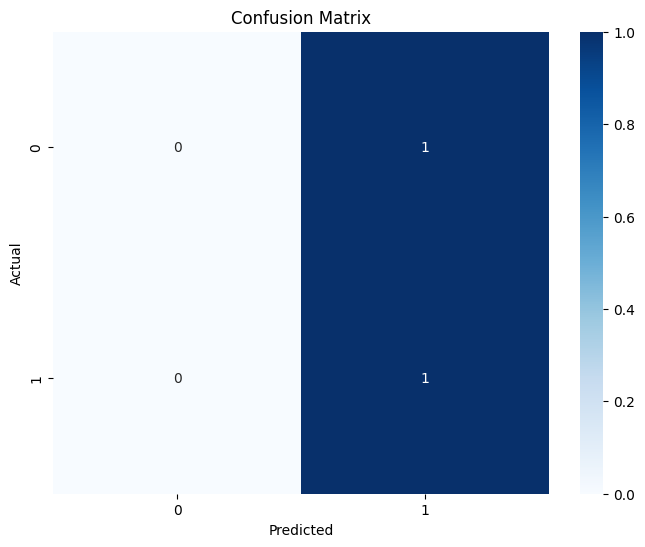

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
from nltk import download

# Unduh stopword bahasa Indonesia
download('stopwords')
stopwords_indonesia = stopwords.words('indonesian')

# Dataset fiktif contoh destinasi wisata
data = {
    'User': [1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
    'Destinasi': ['Bali', 'Yogyakarta', 'Lombok', 'Jakarta', 'Medan', 'Bandung', 'Makassar', 'Bali', 'Medan', 'Yogyakarta'],
    'Deskripsi': [
        'Pantai, budaya, dan kehidupan malam',
        'Warisan budaya, candi, wisata alam',
        'Pantai, gunung, dan petualangan',
        'Ibukota negara, wisata perkotaan',
        'Wisata sejarah, kuliner, dan alam',
        'Kuliner, wisata alam, belanja',
        'Kuliner, wisata sejarah, dan alam',
        'Pantai, budaya, dan kehidupan malam',
        'Wisata sejarah, kuliner, dan alam',
        'Warisan budaya, candi, wisata alam'
    ],
    'Rating': [5, 4, 3, 2, 1, 4, 3, 5, 2, 4]
}

# Membuat DataFrame
df = pd.DataFrame(data)

# Encoding destinasi wisata dan pengguna menjadi integer
dest_map = {dest: idx for idx, dest in enumerate(df['Destinasi'].unique())}
user_map = {user: idx for idx, user in enumerate(df['User'].unique())}
df['Destinasi'] = df['Destinasi'].map(dest_map)
df['User'] = df['User'].map(user_map)

# TF-IDF Vectorizer dengan stopwords bahasa Indonesia
vectorizer = TfidfVectorizer(stop_words=stopwords_indonesia)
tfidf_matrix = vectorizer.fit_transform(df['Deskripsi'])

# Membuat dataset gabungan antara fitur teks dan embedding
X_text = tfidf_matrix.toarray()
X_ncf = df[['User', 'Destinasi']].values
y = df['Rating'].values

# Membagi data menjadi set pelatihan dan pengujian
X_train_text, X_test_text, X_train_ncf, X_test_ncf, y_train, y_test = train_test_split(X_text, X_ncf, y, test_size=0.2, random_state=42)

# Normalisasi nilai rating
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler.transform(y_test.reshape(-1, 1)).flatten()

# Model NCF
n_users = df['User'].nunique()
n_dests = df['Destinasi'].nunique()
embedding_dim = 8

# Input
user_input = Input(shape=(1,))
dest_input = Input(shape=(1,))

# Embedding untuk pengguna dan destinasi
user_embedding = Embedding(input_dim=n_users, output_dim=embedding_dim, input_length=1)(user_input)
dest_embedding = Embedding(input_dim=n_dests, output_dim=embedding_dim, input_length=1)(dest_input)

# Flatten layer
user_vec = Flatten()(user_embedding)
dest_vec = Flatten()(dest_embedding)

# Concatenate dan dense layers
concat = Concatenate()([user_vec, dest_vec])
fc1 = Dense(64, activation='relu')(concat)
fc2 = Dense(32, activation='relu')(fc1)
dropout = Dropout(0.3)(fc2)
output_ncf = Dense(1)(dropout)

# Model NCF
model_ncf = Model([user_input, dest_input], output_ncf)
model_ncf.compile(optimizer=Adam(), loss='mean_squared_error')

# Melatih model NCF
model_ncf.fit([X_train_ncf[:, 0], X_train_ncf[:, 1]], y_train, epochs=10, batch_size=8, verbose=1)

# Prediksi menggunakan NCF
y_pred_ncf = model_ncf.predict([X_test_ncf[:, 0], X_test_ncf[:, 1]])

# Kombinasi Hybrid
# Untuk contoh sederhana, kita akan mengambil rata-rata dari CBF dan NCF sebagai hybrid
y_pred_hybrid = (np.mean(X_test_text, axis=1) + y_pred_ncf.flatten()) / 2

# Evaluasi hasil
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_orig = scaler.inverse_transform(y_pred_hybrid.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))

# Mengonversi nilai rating ke kelas (biner untuk confusion matrix)
threshold = 3.0
y_test_binary = np.where(y_test_orig >= threshold, 1, 0)
y_pred_binary = np.where(y_pred_orig >= threshold, 1, 0)

conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

print("\nConfusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()